In [1]:
import os
import ast
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
writers_info = pd.read_csv('./Data/writers-info.csv')
# selected_lang = ['German', 'French']
# writers_info = writers_info.loc[writers_info['NativeLanguage'].isin(selected_lang)]
# display(writers_info)
writers_name_list = writers_info['name']
images_path = writers_info['images_path']

width_list = []
height_list = []
for name, i  in zip(writers_name_list, images_path):
  print(name)
  i = ast.literal_eval(i)
  for j in i:
    # print(j)
    image_list = glob.glob(j)
    for k in image_list:
      # print(k)
      # img = cv2.imread(k)
      with Image.open(k) as img:
        img = img.size
        width_list.append(img[0])
        height_list.append(img[1])
      # width_list.append(img.shape[1])
      # height_list.append(img.shape[0])
    # print(image_list)

print(width_list)
print(height_list)
print(len(width_list))
print(len(height_list))

10000
10004
10005
10006
10007
10008
10009
10010
10011
10012
10015
10017
10018
10019
10020
10021
10024
10026
10027
10028
10030
10031
10032
10033
10034
10035
10036
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10065
10066
10067
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10094
10095
10096
10097
10098
10099
10100
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10147
10148
10149
10150
10151
10153
10154
10155
10156
10157
10158
10159
10160
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10187
1018

Max Width: 2272
Mean Width: 1766.0
Median Width: 1842.0
98th Percentile Width: 2152.0
Max Height: 1377
Mean Height: 364.0
Median Height: 369.0
98th Percentile Height: 502.0
Selected Width: 2240, Height: 512


<Axes: ylabel='Count'>

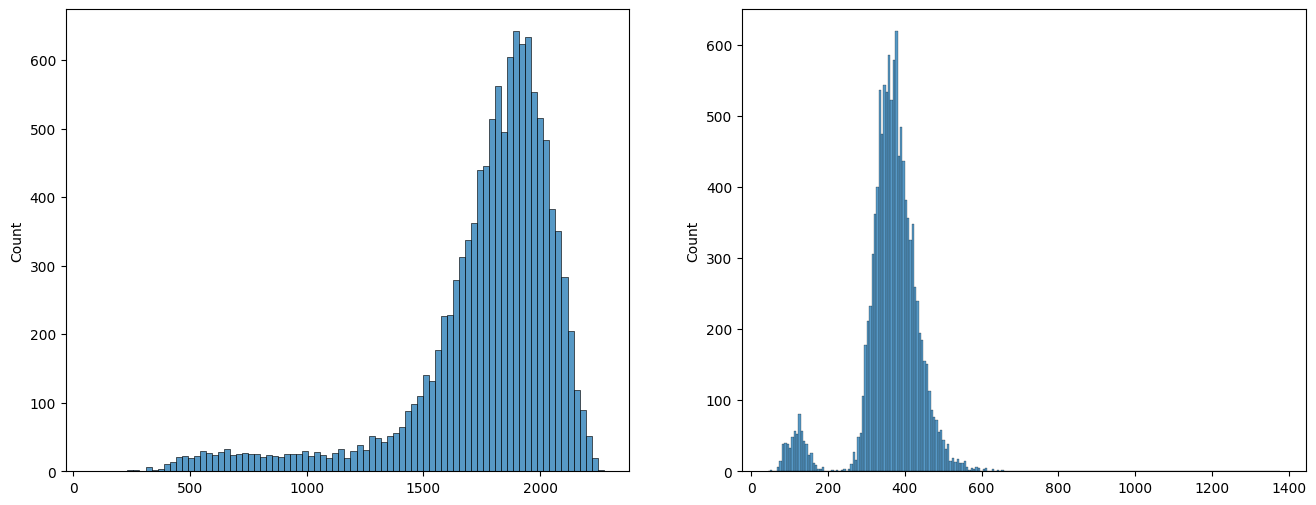

In [3]:
fig, ax = plt.subplots(1,2, figsize = (16,6))

print(f'Max Width: {np.max(width_list)}')
print(f'Mean Width: {np.mean(width_list).round(0)}')
print(f'Median Width: {np.median(width_list).round(0)}')
print(f'98th Percentile Width: {np.percentile(width_list, 98).round(0)}')

print(f'Max Height: {np.max(height_list)}')
print(f'Mean Height: {np.mean(height_list).round(0)}')
print(f'Median Height: {np.median(height_list).round(0)}')
print(f'98th Percentile Height: {np.percentile(height_list, 98).round(0)}')

print('Selected Width: 2240, Height: 512')
sns.histplot(x=width_list,ax=ax[0])
sns.histplot(x=height_list,ax=ax[1])

# ConvNeXtV2 feature extraction for 3 classes classification. (Swiss German, German, French)

In [4]:
from transformers import AutoImageProcessor, ConvNextV2Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input

model_name = []

model = 'facebook/convnextv2-tiny-22k-384'
processor = AutoImageProcessor.from_pretrained(model)
model = ConvNextV2Model.from_pretrained(model)

all_features_data = []
writer_id_list = []
writer_forms_list = []
for name, i in zip(writers_name_list,images_path):
  i = ast.literal_eval(i)
  for j in i:
    # print(j)
    image_list = glob.glob(j)
    for k in image_list:
      # print(k)
      # img = cv2.imread(k)
      with Image.open(k) as img:
        img = img.convert('RGB')
        original_width, original_height = img.size
        # print(original_width)
        new_width = int(original_width * (512 / original_height))
        # print(new_width)
        resized_img = img.resize((new_width, 512), Image.Resampling.LANCZOS)
        
        if resized_img.width > 2160:
            # THE OUTLIER CASE: If the resized image is still too wide,
            # we perform a second resize to SQUASH it to fit.
            final_img = resized_img.resize((2160, 512), Image.Resampling.LANCZOS)
        else:
            # THE NORMAL CASE: If the image fits,
            # create a blank white canvas and paste the image onto it.
            final_img = Image.new('RGB', (2160, 512), 'white')
            final_img.paste(resized_img, (0, 0))
      
        inputs = processor(images=final_img, return_tensors='pt')
        
        outputs = model(**inputs)
        features = outputs.pooler_output.detach().numpy()
        # last_hidden_states = outputs.last_hidden_state
        # print(last_hidden_states.shape)
        # features = last_hidden_states[:, 0, :]
        # print(features)
        # Store the results
        image_form = os.path.splitext(os.path.basename(k))[0]
        writer_forms_list.append(image_form)
        writer_id_list.append(name)
        all_features_data.append(features.flatten().tolist())
        # save_path = k.find('Data')
        # save_path = k[:7] + 'Formatted-Data/' + k[7:]
        # dir_path = os.path.dirname(save_path)
        # os.makedirs(dir_path, exist_ok=True)
        # # print(save_path, 'TIF')
        # final_img.save(save_path)

writer_features_df = pd.DataFrame(data=all_features_data)
writer_features_df['name'] = writer_id_list
writer_features_df['form'] = writer_forms_list
# writer_features_df = pd.DataFrame(writer_features_df[2].tolist(),index=writer_features_df[0])
# print(all_features_data)
writer_features_df

/Users/veeranonthuvasin/Desktop/MSc-Data-Science-Bristol/Dissertation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,name,form
0,-0.571697,1.261460,-0.896962,-2.045485,-0.657558,0.688311,0.872243,0.098738,-2.745424,-0.629436,...,0.073616,0.355277,-1.274841,0.215828,-0.210847,1.906537,1.892051,0.716024,10000,z01-000-03
1,-0.617401,1.683710,-0.370848,-1.771416,-0.377822,0.695021,1.095721,0.229832,-2.860271,-0.851637,...,0.468921,-0.202906,-1.045198,0.225852,-0.187759,1.526179,1.526659,0.196687,10000,z01-000-02
2,-0.448969,1.685365,-0.494149,-1.598047,-0.663917,0.730870,0.561499,0.177013,-2.670420,-0.694397,...,0.045399,-0.483041,-1.045340,0.304602,-0.192579,1.245093,1.194240,0.507740,10000,z01-000-01
3,-0.686448,1.668089,-0.316621,-2.181799,-0.858133,0.753625,1.079461,0.280941,-2.786654,-0.295809,...,0.339464,-0.205931,-0.935900,0.188087,-0.305182,1.241609,1.134542,0.068986,10000,z01-000-05
4,-0.675996,1.205480,-0.980199,-2.511955,-0.411895,0.513013,1.161943,0.316724,-3.077692,-0.523500,...,0.232323,0.186722,-1.190333,0.255973,-0.101695,1.327156,1.257383,0.397528,10000,z01-000-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11672,-0.851204,1.772579,-0.339566,-2.171310,-1.370676,0.408270,0.143344,0.063972,-1.841539,-0.459425,...,-0.228844,0.145350,-0.929089,0.681607,-0.464654,1.364797,1.459228,0.645048,10220,r09-711z-01
11673,-0.997527,0.565793,-0.164430,-1.997548,-0.772364,0.746590,0.258118,-0.040935,-2.194748,0.005941,...,-0.507745,-0.228313,-0.765564,0.152436,-0.693647,1.909404,2.179794,0.659266,10220,r09-711z-05
11674,-0.535618,1.022329,-0.488236,-1.811373,-1.018522,0.691729,0.448730,-0.084652,-2.315323,-0.463091,...,-0.186937,-0.095367,-0.965840,0.375361,-0.355476,1.562921,1.856481,0.555189,10220,r09-711z-04
11675,-0.542497,0.774787,-0.923842,-2.091343,-0.822547,0.356091,0.424894,0.072178,-2.449055,-0.557856,...,-0.254058,-0.045749,-1.156777,0.583077,-0.129757,1.490528,1.926554,1.005996,10220,r09-711z-06


In [5]:
writer_features_df.to_csv('./writer_features_df_updated_3_classes_ConvNeXtV2.csv')


In [6]:
writer_features_df

writer_group_test = writer_features_df.groupby('name')[writer_features_df.columns[:-1]].agg(['mean','std'])
writer_group_test.columns = writer_group_test.columns.map(lambda x: '|'.join(map(str, x)))
writer_group_test

,0|mean,0|std,1|mean,1|std,2|mean,2|std,3|mean,3|std,4|mean,4|std,...,764|mean,764|std,765|mean,765|std,766|mean,766|std,767|mean,767|std,name|mean,name|std
name,,,,,,,,,,,,,,,,,,,,,
10000,-0.470757,0.189049,1.699413,0.338440,-0.224565,0.505689,-1.706684,0.616108,-0.726862,0.250390,...,-0.334098,0.223373,1.452440,0.229580,1.301115,0.322759,0.212060,0.345890,10000.0,0.0
10004,-0.878848,0.352955,0.544866,0.714501,-0.720909,0.577211,-2.173683,0.628408,-0.434018,0.610542,...,-0.463886,0.236431,1.266248,0.491298,1.322939,0.760476,0.856123,0.311928,10004.0,0.0
10005,-0.892455,0.421203,0.371126,0.938319,-0.385092,0.461880,-2.261231,0.770752,-0.417356,0.521892,...,-0.412412,0.282949,1.235648,0.462115,1.441056,0.517920,0.716954,0.564789,10005.0,0.0
10006,-0.786353,0.363073,1.013398,0.643333,-0.492740,0.621075,-2.060224,0.820599,-0.539872,0.684531,...,-0.501251,0.237210,1.250010,0.667813,1.060852,0.729497,0.665219,0.409446,10006.0,0.0
10007,-0.612247,0.293455,0.973429,0.466973,-0.738974,0.729919,-1.996205,0.703257,-0.633232,0.452700,...,-0.387980,0.251408,1.271903,0.499715,1.648168,0.400056,0.677284,0.350817,10007.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10215,-0.616953,0.142556,1.296880,0.216118,-0.676058,0.281599,-2.007938,0.287979,-0.846598,0.200905,...,-0.317560,0.243703,1.368769,0.249196,1.458046,0.250665,0.772833,0.195109,10215.0,0.0
10217,-0.526434,0.133031,1.671324,0.211037,-0.410205,0.338271,-1.708432,0.271414,-0.929699,0.162006,...,-0.327279,0.154601,1.467731,0.205427,1.298549,0.252222,0.527538,0.228328,10217.0,0.0
10218,-0.603442,0.137698,1.566055,0.304288,-0.612232,0.457367,-1.747215,0.387648,-0.790210,0.182630,...,-0.215342,0.197578,1.372466,0.198861,1.356417,0.291967,0.183866,0.222579,10218.0,0.0


In [7]:
full_writer_features_df = pd.merge(writers_info[['name','Gender','NativeLanguage','WritingType']], writer_group_test.iloc[: ,:-2], how='inner', left_on='name', right_index=True)

full_writer_features_df

,name,Gender,NativeLanguage,WritingType,0|mean,0|std,1|mean,1|std,2|mean,2|std,...,763|mean,763|std,764|mean,764|std,765|mean,765|std,766|mean,766|std,767|mean,767|std
0,10000,Male,German,Right-handed,-0.470757,0.189049,1.699413,0.338440,-0.224565,0.505689,...,0.143204,0.161367,-0.334098,0.223373,1.452440,0.229580,1.301115,0.322759,0.212060,0.345890
1,10004,Male,French,Right-handed,-0.878848,0.352955,0.544866,0.714501,-0.720909,0.577211,...,-0.046882,0.676105,-0.463886,0.236431,1.266248,0.491298,1.322939,0.760476,0.856123,0.311928
2,10005,Male,Swiss German,Right-handed,-0.892455,0.421203,0.371126,0.938319,-0.385092,0.461880,...,-0.276602,0.682543,-0.412412,0.282949,1.235648,0.462115,1.441056,0.517920,0.716954,0.564789
3,10006,Female,Swiss German,Right-handed,-0.786353,0.363073,1.013398,0.643333,-0.492740,0.621075,...,0.016002,0.636077,-0.501251,0.237210,1.250010,0.667813,1.060852,0.729497,0.665219,0.409446
4,10007,Male,French,Right-handed,-0.612247,0.293455,0.973429,0.466973,-0.738974,0.729919,...,0.252265,0.342678,-0.387980,0.251408,1.271903,0.499715,1.648168,0.400056,0.677284,0.350817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,10215,Male,Swiss German,Left-handed,-0.616953,0.142556,1.296880,0.216118,-0.676058,0.281599,...,0.188149,0.236456,-0.317560,0.243703,1.368769,0.249196,1.458046,0.250665,0.772833,0.195109
193,10217,Male,Swiss German,Left-handed,-0.526434,0.133031,1.671324,0.211037,-0.410205,0.338271,...,0.289040,0.171220,-0.327279,0.154601,1.467731,0.205427,1.298549,0.252222,0.527538,0.228328
194,10218,Male,Swiss German,Right-handed,-0.603442,0.137698,1.566055,0.304288,-0.612232,0.457367,...,0.152348,0.163926,-0.215342,0.197578,1.372466,0.198861,1.356417,0.291967,0.183866,0.222579
195,10219,Female,French,Right-handed,-0.727730,0.188590,1.096299,0.294827,-0.619716,0.309114,...,0.253052,0.210974,-0.307135,0.221386,1.251799,0.255432,1.574014,0.226741,0.543729,0.251043


In [8]:
full_writer_features_df.to_csv('full_final_writer_df_3_classes_ConvNeXtV2.csv',index=False)